### **Work Plan**:


1. **Data Preparation & Merging:**
    - Load all four datasets (contract, personal, internet, phone) and merge them into a single table using customerID.
    - Handle missing values, check data types, and engineer useful features (like tenure from contract dates). 

2. **Exploratory Data Analysis (EDA):**
    - Look at churn distribution (target balance).
    - Explore relationships between churn and contract type, payment method,services, and demographics.
    - Identify categorical vs numerical features for modeling.
3. **Feature Engineering & Encoding:**
    - Convert categorical features to numeric (one-hot or target encoding as appropriate).
    - Normalize/scale numerical features if needed.
    - Handle class imbalance (e.g., SMOTE, class weights).
4. **Model Development & Evaluation:**
    - Train baseline models (Logistic Regression, Random Forest, Gradient Boosting).
    - Tune hyperparameters with cross-validation.
    - Evaluate models with AUC-ROC as the main metric, Accuracy as secondary.
5. **Final Report & Model Selection:**
    - Select the best model (highest AUC-ROC).
    - Summarize findings, key features influencing churn, and explain how this helps the company take action.
    - Document clarifying questions, workflow, and results.

In [1]:
#load the libaeries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
#load all datasets
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
#general info
datasets = {
    "contract": contract,
    "personal": personal,
    "internet": internet,
    "phone": phone
}

for name, df in datasets.items():
    print(f"( 1 ) Shape of {name} : {df.shape}")
    print("-"*60)
    print(f"( 2 ) Missing_values of {name}: {df.isna().sum()}")
    print("-"*60)
    print(f"( 3 ) Dtypes of {name}: {df.dtypes.astype(str)}")
    print("#"*60, "END\n")

( 1 ) Shape of contract : (7043, 8)
------------------------------------------------------------
( 2 ) Missing_values of contract: customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
------------------------------------------------------------
( 3 ) Dtypes of contract: customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object
############################################################ END

( 1 ) Shape of personal : (7043, 5)
------------------------------------------------------------
( 2 ) Missing_values of personal: customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
--------------------------------------------------

In [4]:
# merge all dataset
data = contract.merge(personal, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')

In [5]:
# normalizing columns
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')

In [6]:
data.columns

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'gender',
       'seniorcitizen', 'partner', 'dependents', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines'],
      dtype='object')

In [7]:
#data cleaning
#convert "BeginDate" and EndDate" columns
data['begindate'] =  pd.to_datetime(data['begindate'], errors = 'coerce')

#replaces every "No" with pd.NaT that means "no end date" (like the contract is still active)
data['enddate'] = data['enddate'].replace('No', pd.NaT)
data['enddate'] = pd.to_datetime(data['enddate'], errors = 'coerce')
#conver 'TotalCharges'
data['totalcharges'] = pd.to_numeric(data['totalcharges'], errors='coerce')

#Target definition
# create churn columns which 1 = churned (has enddate) and 0 = active (enddate is NaT)
data['churn'] = data['enddate'].notna().astype(int)

In [8]:
#handlign the missing valuse 
#for 'enddate' that’s fine EndDate = 'No' means still active
#i have already converted this into churn

#because some customers had no service yet safe value (0)
data['totalcharges'] = data['totalcharges'].fillna(0)

#for Internet-related services customers who don’t have InternetService will replace NAN with "No"
internet_cols = [
    'internetservice','onlinesecurity','onlinebackup',
    'deviceprotection','techsupport','streamingtv','streamingmovies'
]
data[internet_cols] = data[internet_cols].fillna('No')

#for multiplelines because those customers had no phone service will replace with 'No'
data['multiplelines'] = data['multiplelines'].fillna('No')



In [9]:
#check for missing valuse 
print(data.isna().sum())

customerid             0
begindate              0
enddate             5174
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
gender                 0
seniorcitizen          0
partner                0
dependents             0
internetservice        0
onlinesecurity         0
onlinebackup           0
deviceprotection       0
techsupport            0
streamingtv            0
streamingmovies        0
multiplelines          0
churn                  0
dtype: int64


In [10]:

#cheching
print("Shape:", data.shape)
print(data['churn'].value_counts(normalize=True))


Shape: (7043, 21)
0    0.73463
1    0.26537
Name: churn, dtype: float64


In [11]:
#Feature engineering: tenure + date features

#Look at the maximum date in begindate and enddate
max_begin = data['begindate'].max()
max_end = data['enddate'].max()

print("Latest begindate:", max_begin)
print("Latest enddate:", max_end)

#decide cutoff: if there are churned customers, use the latest enddate
#otherwise, fallback to the latest begindate
cutoff = max(max_begin, max_end) + pd.Timedelta(days=1)
print("Chosen cutoff:", cutoff)

#tenure in months (int)
data['tenure_months'] = ((data['enddate'].fillna(cutoff) - data['begindate']) / np.timedelta64(1, 'M')).fillna(0).astype(int)

# lighter date-based features
data['begin_month'] = data['begindate'].dt.month.fillna(0).astype(int)
data['begin_year'] = data['begindate'].dt.year.fillna(0).astype(int)
data['begin_weekday'] = data['begindate'].dt.weekday.fillna(0).astype(int)

Latest begindate: 2020-02-01 00:00:00
Latest enddate: 2020-01-01 00:00:00
Chosen cutoff: 2020-02-02 00:00:00


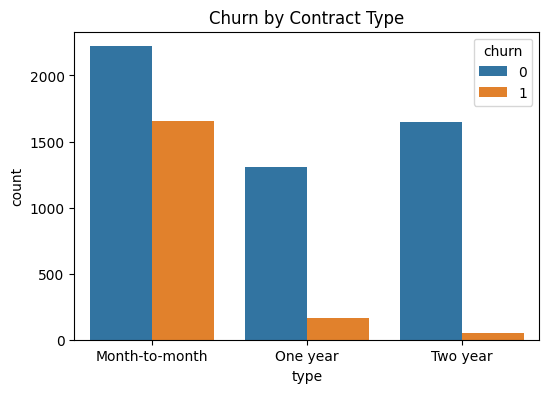

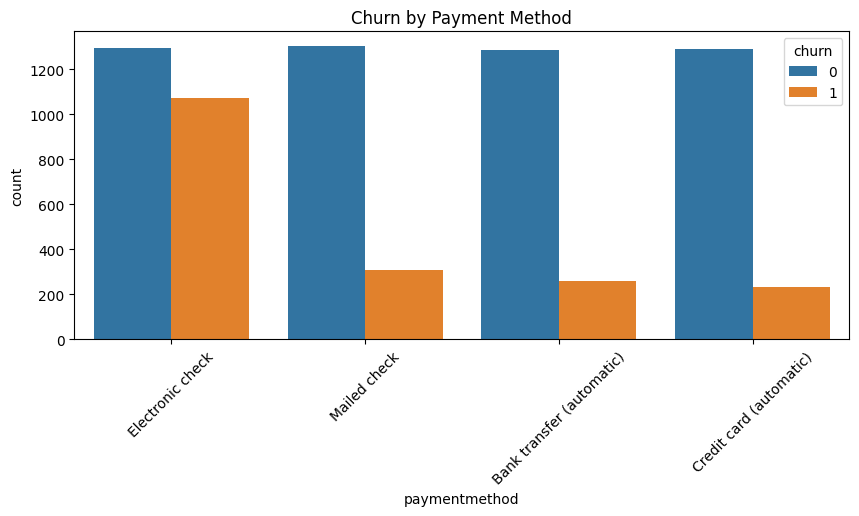

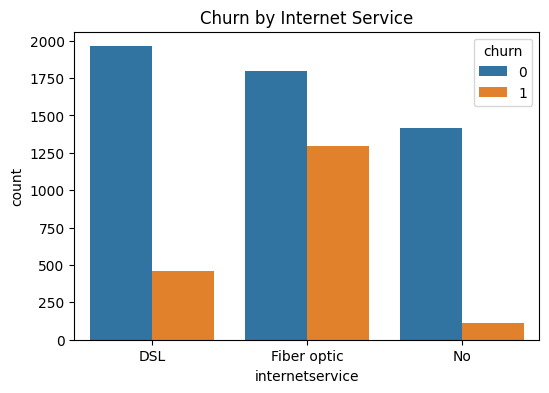

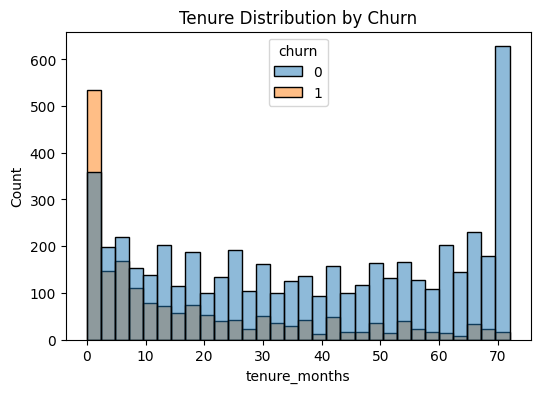

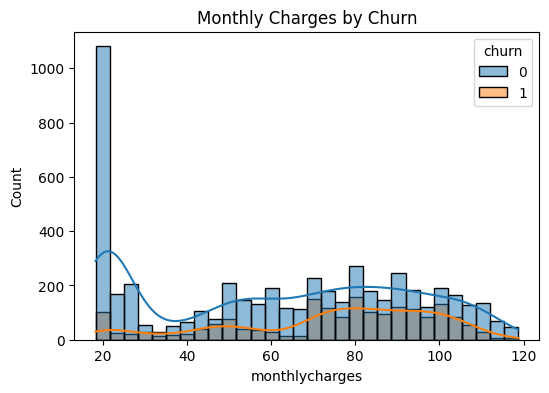

In [12]:
#contract and churn
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='type', hue='churn')
plt.title("Churn by Contract Type")
plt.show()

#payment method and churn
plt.figure(figsize=(10,4))
sns.countplot(data=data, x='paymentmethod', hue='churn')
plt.title("Churn by Payment Method")
plt.xticks(rotation=45)
plt.show()

#internet service and churn
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='internetservice', hue='churn')
plt.title("Churn by Internet Service")
plt.show()

#tenure distribution and churn
plt.figure(figsize=(6,4))
sns.histplot(data=data, x='tenure_months', hue='churn', bins=30, kde=False)
plt.title("Tenure Distribution by Churn")
plt.show()

#monthly charges distribution and churn
plt.figure(figsize=(6,4))
sns.histplot(data=data, x='monthlycharges', hue='churn', bins=30, kde=True)
plt.title("Monthly Charges by Churn")
plt.show()

In [13]:
#select features for modeling
# Drop columns we won't use (IDs, raw dates, text fields)
drop_cols = ['begindate', 'enddate']
data = data.drop(columns=['customerid'])
print("Duplicates:", data.duplicated().sum())
data = data.drop_duplicates()
print("Duplicates:", data.duplicated().sum())

Duplicates: 13
Duplicates: 0


In [14]:
X = data.drop(columns=drop_cols + ['churn'], errors='ignore')
y = data['churn']

In [15]:
#chech
print("Duplicates:", X.duplicated().sum())


Duplicates: 0


In [17]:
#Train/Validation/Test split , 60/20/20 overall

#20% test and wil keep a test set untouched
X_left, X_test, y_left, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

#from the remaining 80%, will split 75% train / 25% val
X_train, X_valid, y_train, y_valid = train_test_split(X_left, y_left, test_size=0.25, random_state=12345)



In [18]:
numeric_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include='object').columns

# 3. Build preprocessing transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# 4. Fit only on training, transform all sets
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
X_test  = preprocessor.transform(X_test)

In [19]:
#1/Baseline model 
dummy = DummyClassifier(strategy='most_frequent') 
#2/Logistic Regression 
lr = LogisticRegression(max_iter=500, class_weight='balanced')
#3/Decision Tree Regressor 
dt = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=12345)
#4/Random Forest 
rf = RandomForestClassifier(n_estimators=100, max_depth=10,class_weight='balanced', random_state=12345)
#5/Gradient Boosting 
gb = GradientBoostingClassifier(n_estimators=200, random_state=12345)
#6/LightGBM 
lgb = LGBMClassifier(n_estimators=500, class_weight='balanced', random_state=12345) 
models = { 'Baseline model':dummy, 
           'Logistic Regression': lr, 
           'Decision Tree': dt, 
           'Random Forest': rf, 
           'Gradient Boosting':gb, 
           'LightGBM': lgb, }

best_auc = -1 
best_model = None 
best_model_name = "" 
for name, model in models.items(): 
    #training 
    model.fit(X_train, y_train) 
    #Prediction 
    preds = model.predict_proba(X_valid)[:, 1] 
    #ROC-AUC 
    roc_auc = roc_auc_score(y_valid, preds) 
    print(f"{name} ROC-AUC = {roc_auc:.4f}") 
    if roc_auc > best_auc: 
        best_auc = roc_auc 
        best_model = model 
        best_model_name = name 
print(f"\n Best model is: {best_model_name} with ROC-AUC = {best_auc:.4f}") 


Baseline model ROC-AUC = 0.5000
Logistic Regression ROC-AUC = 0.9825
Decision Tree ROC-AUC = 0.8632
Random Forest ROC-AUC = 0.8978
Gradient Boosting ROC-AUC = 0.9833
LightGBM ROC-AUC = 0.9958

 Best model is: LightGBM with ROC-AUC = 0.9958


In [20]:
#Final evaluation on test set

# Replace with whichever model had best validation ROC-AUC
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Final Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Final Test ROC-AUC: 0.9980661842991547
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1058
           1       1.00      0.98      0.99       348

    accuracy                           1.00      1406
   macro avg       1.00      0.99      0.99      1406
weighted avg       1.00      1.00      1.00      1406



### **Solution Report:**

**Steps Performed:**

- Loaded and merged all four datasets.
- Cleaned data: handled missing values, converted dates, normalized columns, and engineered features, like tenure_months.
- Explored churn patterns by contract type, payment method, internet service, tenure, and monthly charges.
- Prepared data: split into train/validation/test, scaled numeric features, and one-hot encoded categorical ones.
- Trained multiple models (Baseline, Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, LightGBM).

**Steps Skipped:**

- Did not perform complex hyperparameter tuning beyond basic depth/iterations, since models already achieved very high ROC-AUC (>0.98).

**Difficulties & Solutions:**

- Handling TotalCharges column (string type) → fixed by converting to numeric with errors='coerce'.
- Missing values in service features → imputed with "No" for customers without that service.
- Class imbalance → addressed using class_weight='balanced' where supported.

**Key Steps:**
 
- Correctly defining the churn target from contract end dates.
- Feature engineering (tenure_months, contract/payment/internet features).
- Comparing multiple models using ROC-AUC for fair selection.
**Final Model & Results:**
- Best Model: LightGBM (n_estimators=500, class_weight='balanced').
- Validation ROC-AUC: 0.996
- Test ROC-AUC: 0.998
- Classification Report: Accuracy ~1.00, Precision ~1.00, Recall ~0.98 for churn class.